In [15]:
import time
import numpy as np
import torch

import src.utils as ut
from src.SCMMappings_1_1 import Abstraction
from src.printing import AbstractionPrinter

import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork as BN
from pgmpy.factors.discrete import TabularCPD as cpd

In [16]:
seed = 0
np.random.seed(seed)  # Numpy module
torch.manual_seed(seed)

In [17]:
from src.examples import smokingmodels as ex

In [18]:
A_basic = Abstraction(*ex.basic_lung_cancer())
A_collapsing = Abstraction(*ex.collapsing_lung_cancer())
A_extended = Abstraction(*ex.extended_lung_cancer())
A_vstruct = Abstraction(*ex.vstruct_lung_cancer())


In [19]:
import src.evaluationsets as es
import src.learning as lng

In [20]:
J_basic = es.get_causal_sets_in_M1_with_directed_path_in_M1_and_M0(A_basic.M0, A_basic.M1, A_basic.a)

In [21]:
J_collapsing = [[['Smoking_'], ['Tar_']],
 [['Smoking_'], ['Cancer_']],
 [['Tar_'], ['Cancer_']]]

In [22]:
J_extended = [[['Smoking_'], ['Tar_']],
 [['Smoking_'], ['Cancer_']],
 [['Tar_'], ['Cancer_']]]

In [23]:
J_vstruct = [[['Smoking_'], ['Cancer_']],
 [['Smoking_'], ['Fatigue_']],
 [['Cancer_'], ['Fatigue_']]]

In [24]:
from src.nn import JointNeuralNet
from src.nn_losses import JSD_loss,RowMax_penalty

In [25]:
def calc_distance(Ws, alpha_index, alphas):
    distance = 0.0
    for key, value in alpha_index.items():
        distance += torch.sum(torch.abs(torch.from_numpy(alphas[key])-Ws[value]))
    return distance

In [26]:
def train_a_SequentialNN_model(M0, M1, R, a, alphas, J, Ws, T, lmbda, num_epochs, lr):
    learned_alphas = {}
    distances = np.zeros((num_epochs))
    jsds = np.zeros((num_epochs))
    pens = np.zeros((num_epochs))
    end_results = {}
    num_dias = 0

    for j in J:

        if not(ut.is_list_contained_in_list(j[0]+j[1], list(learned_alphas.keys()))):
            num_dias += 1

            model = JointNeuralNet(M0, M1, R, a, [j], T, frozen_alphas=learned_alphas)

            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion_jsd = JSD_loss()
            criterion_pen = RowMax_penalty()

            for epoch in range(num_epochs):
                lowpaths, highpaths, Ws = model()
                loss_jsd = criterion_jsd(lowpaths, highpaths)
                loss_pen = criterion_pen(Ws)
                loss = lmbda * loss_jsd + loss_pen
                
                distances[epoch] += calc_distance(Ws, model.alpha_index, alphas)
                jsds[epoch] += loss_jsd
                pens[epoch] += loss_pen
                

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if (epoch + 1) % 500 == 0:
                    print('Epoch [{}/{}], Loss: {:.4f}, JSD: {:.4f}, Penalty: {:.4f}'.format(epoch + 1, num_epochs, loss,
                                                                                             loss_jsd, loss_pen))

            for name in model.alphas_to_learn:
                learned_alphas[name] = model.get_Wmatrix_by_name(name).detach()
    
    # discretize alphas and calc_distance
    discretized_alphas = {}
    for name, value in learned_alphas.items():
        tmp = torch.zeros((value.shape))
        for i in range(value.shape[1]):
            tmp[torch.argmax(value[:,i]),i] = 1
        discretized_alphas[name] = tmp
    
    #calculate distance with discrete learnt alphas
    end_distance = 0.0
    for key, value in alphas.items():
        end_distance += torch.sum(torch.abs(torch.from_numpy(alphas[key])-discretized_alphas[key]))
    
    # jsd and penalty with initalised discrete alphas
    criterion_jsd = JSD_loss()
    criterion_pen = RowMax_penalty()
    end_model = JointNeuralNet(M0,M1,R,a,J,T,initialised_alphas=discretized_alphas)
    lowpaths, highpaths, Ws = end_model()    
    end_loss_jsd = criterion_jsd(lowpaths, highpaths)
    end_loss_pen = criterion_pen(Ws)
    
    # store end results
    end_results['normalised_alphas'] = learned_alphas
    end_results['discretized_alpha'] = discretized_alphas
    end_results['jsd'] = end_loss_jsd
    end_results['penalty'] = end_loss_pen
    end_results['distance'] = end_distance
                
                

    return distances/len(alphas), jsds/num_dias, pens/len(alphas), end_results



In [27]:
lr = 0.01
num_epochs = 500
T = 0.1
lmbda=10.0
n_fold = 10
k_fold = 10

In [28]:
n_best_distance1 = np.zeros((n_fold,num_epochs))
n_best_jsd1 = np.zeros((n_fold,num_epochs))
n_best_pen1 = np.zeros((n_fold,num_epochs))
n_best_end_results1 = []
n_time1 = np.zeros((n_fold))

n_best_distance2 = np.zeros((n_fold,num_epochs))
n_best_jsd2 = np.zeros((n_fold,num_epochs))
n_best_pen2 = np.zeros((n_fold,num_epochs))
n_best_end_results2 = []
n_time2 = np.zeros((n_fold))

n_best_distance3 = np.zeros((n_fold,num_epochs))
n_best_jsd3 = np.zeros((n_fold,num_epochs))
n_best_pen3 = np.zeros((n_fold,num_epochs))
n_best_end_results3 = []
n_time3 = np.zeros((n_fold))

n_best_distance4 = np.zeros((n_fold,num_epochs))
n_best_jsd4 = np.zeros((n_fold,num_epochs))
n_best_pen4 = np.zeros((n_fold,num_epochs))
n_best_end_results4 = []
n_time4 = np.zeros((n_fold))


for n in range(n_fold):
    print(f"n fold {n+1}:")

    k_distances1 = np.zeros((k_fold,num_epochs))
    k_jsds1 = np.zeros((k_fold,num_epochs))
    k_pens1 = np.zeros((k_fold,num_epochs))
    k_end_results1 = []
    k_time1 = np.zeros((k_fold))
    
    k_distances2 = np.zeros((k_fold,num_epochs))
    k_jsds2 = np.zeros((k_fold,num_epochs))
    k_pens2 = np.zeros((k_fold,num_epochs))
    k_end_results2 = []
    k_time2 = np.zeros((k_fold))
    
    k_distances3 = np.zeros((k_fold,num_epochs))
    k_jsds3 = np.zeros((k_fold,num_epochs))
    k_pens3 = np.zeros((k_fold,num_epochs))
    k_end_results3 = []
    k_time3 = np.zeros((k_fold))
    
    k_distances4 = np.zeros((k_fold,num_epochs))
    k_jsds4 = np.zeros((k_fold,num_epochs))
    k_pens4 = np.zeros((k_fold,num_epochs))
    k_end_results4 = []
    k_time4 = np.zeros((k_fold))
    
    for fold in range(k_fold):
        st = time.time()
        distances_epoch1, jsds1, pens1, end_results1 = train_a_SequentialNN_model(A_basic.M0, A_basic.M1, A_basic.R, A_basic.a, A_basic.alphas, J_basic,
                     Ws=None, T=T, lmbda=lmbda, num_epochs=num_epochs, lr=lr)
        et = time.time()
        time1 = et - st
        
        st = time.time()
        distances_epoch2, jsds2, pens2, end_results2 = train_a_SequentialNN_model(A_collapsing.M0, A_collapsing.M1, A_collapsing.R, A_collapsing.a, A_collapsing.alphas, J_collapsing,
                     Ws=None, T=T, lmbda=lmbda, num_epochs=num_epochs, lr=lr)
        et = time.time()
        time2 = et - st
        
        st = time.time()
        distances_epoch3, jsds3, pens3, end_results3 = train_a_SequentialNN_model(A_extended.M0, A_extended.M1, A_extended.R, A_extended.a, A_extended.alphas, J_extended,
                     Ws=None, T=T, lmbda=lmbda, num_epochs=num_epochs, lr=lr)
        et = time.time()
        time3 = et - st
        
        st = time.time()
        distances_epoch4, jsds4, pens4, end_results4 = train_a_SequentialNN_model(A_vstruct.M0, A_vstruct.M1, A_vstruct.R, A_vstruct.a, A_vstruct.alphas, J_vstruct,
                     Ws=None, T=T, lmbda=lmbda, num_epochs=num_epochs, lr=lr)
        et = time.time()
        time4 = et - st
        
        
        k_distances1[fold] = distances_epoch1
        k_jsds1[fold] = jsds1
        k_pens1[fold] = pens1
        k_end_results1.append(end_results1)
        k_time1[fold] = time1
        
        k_distances2[fold] = distances_epoch2
        k_jsds2[fold] = jsds2
        k_pens2[fold] = pens2
        k_end_results2.append(end_results2)
        k_time2[fold] = time2
        
        k_distances3[fold] = distances_epoch3
        k_jsds3[fold] = jsds3
        k_pens3[fold] = pens3
        k_end_results3.append(end_results3)
        k_time3[fold] = time3
        
        k_distances4[fold] = distances_epoch4
        k_jsds4[fold] = jsds4
        k_pens4[fold] = pens4
        k_end_results4.append(end_results4)
        k_time4[fold] = time4
        
    k_losses1 = k_jsds1+k_pens1
    k_losses2 = k_jsds2+k_pens2
    k_losses3 = k_jsds3+k_pens3
    k_losses4 = k_jsds4+k_pens4
    best1 = np.argmin(k_losses1[:,-1])
    best2 = np.argmin(k_losses2[:,-1])
    best3 = np.argmin(k_losses3[:,-1])
    best4 = np.argmin(k_losses4[:,-1])
    
    n_best_distance1[n] = k_distances1[best1]
    n_best_jsd1[n] = k_jsds1[best1]
    n_best_pen1[n] = k_pens1[best1]
    n_best_end_results1.append(k_end_results1[best1])
    n_time1[n] = k_time1[best1]
    
    n_best_distance2[n] = k_distances2[best2]
    n_best_jsd2[n] = k_jsds2[best2]
    n_best_pen2[n] = k_pens2[best2]
    n_best_end_results2.append(k_end_results2[best2])
    n_time2[n] = k_time2[best2]
    
    n_best_distance3[n] = k_distances3[best3]
    n_best_jsd3[n] = k_jsds3[best3]
    n_best_pen3[n] = k_pens3[best3]
    n_best_end_results3.append(k_end_results3[best3])
    n_time3[n] = k_time3[best3]
    
    n_best_distance4[n] = k_distances4[best4]
    n_best_jsd4[n] = k_jsds4[best4]
    n_best_pen4[n] = k_pens4[best4]
    n_best_end_results4.append(k_end_results4[best4])
    n_time4[n] = k_time4[best4]
        
        

n fold 1:
Epoch [500/500], Loss: 0.0046, JSD: 0.0004, Penalty: 0.0006
Epoch [500/500], Loss: 0.4265, JSD: 0.0063, Penalty: 0.3638
Epoch [500/500], Loss: 1.5719, JSD: 0.0891, Penalty: 0.6811
Epoch [500/500], Loss: 0.0084, JSD: 0.0006, Penalty: 0.0027
Epoch [500/500], Loss: 0.0053, JSD: 0.0005, Penalty: 0.0000
Epoch [500/500], Loss: 0.8426, JSD: 0.0013, Penalty: 0.8295
Epoch [500/500], Loss: 0.2742, JSD: 0.0273, Penalty: 0.0009
Epoch [500/500], Loss: 1.3285, JSD: 0.0093, Penalty: 1.2351
Epoch [500/500], Loss: 0.0777, JSD: 0.0016, Penalty: 0.0618
Epoch [500/500], Loss: 0.0063, JSD: 0.0006, Penalty: 0.0003
Epoch [500/500], Loss: 0.4948, JSD: 0.0070, Penalty: 0.4250
Epoch [500/500], Loss: 0.4637, JSD: 0.0138, Penalty: 0.3255
Epoch [500/500], Loss: 0.7767, JSD: 0.0013, Penalty: 0.7636
Epoch [500/500], Loss: 0.0174, JSD: 0.0015, Penalty: 0.0020
Epoch [500/500], Loss: 0.0055, JSD: 0.0004, Penalty: 0.0017
Epoch [500/500], Loss: 0.3990, JSD: 0.0033, Penalty: 0.3658
Epoch [500/500], Loss: 1.5623,

Epoch [500/500], Loss: 1.3351, JSD: 0.1009, Penalty: 0.3261
Epoch [500/500], Loss: 1.1935, JSD: 0.0628, Penalty: 0.5654
Epoch [500/500], Loss: 0.7012, JSD: 0.0701, Penalty: 0.0000
n fold 3:
Epoch [500/500], Loss: 2.0149, JSD: 0.0836, Penalty: 1.1789
Epoch [500/500], Loss: 0.4063, JSD: 0.0045, Penalty: 0.3614
Epoch [500/500], Loss: 1.5495, JSD: 0.0870, Penalty: 0.6796
Epoch [500/500], Loss: 1.3259, JSD: 0.0638, Penalty: 0.6877
Epoch [500/500], Loss: 0.4210, JSD: 0.0412, Penalty: 0.0092
Epoch [500/500], Loss: 0.7786, JSD: 0.0033, Penalty: 0.7452
Epoch [500/500], Loss: 0.1840, JSD: 0.0184, Penalty: 0.0002
Epoch [500/500], Loss: 0.0055, JSD: 0.0003, Penalty: 0.0024
Epoch [500/500], Loss: 0.1838, JSD: 0.0060, Penalty: 0.1240
Epoch [500/500], Loss: 0.0475, JSD: 0.0031, Penalty: 0.0169
Epoch [500/500], Loss: 0.9266, JSD: 0.0031, Penalty: 0.8958
Epoch [500/500], Loss: 0.9345, JSD: 0.0610, Penalty: 0.3245
Epoch [500/500], Loss: 0.8676, JSD: 0.0034, Penalty: 0.8334
Epoch [500/500], Loss: 0.9568,

Epoch [500/500], Loss: 0.7712, JSD: 0.0182, Penalty: 0.5893
Epoch [500/500], Loss: 1.3202, JSD: 0.0655, Penalty: 0.6650
Epoch [500/500], Loss: 1.6000, JSD: 0.1342, Penalty: 0.2579
Epoch [500/500], Loss: 2.5211, JSD: 0.2520, Penalty: 0.0007
Epoch [500/500], Loss: 0.7716, JSD: 0.0007, Penalty: 0.7643
Epoch [500/500], Loss: 0.0342, JSD: 0.0034, Penalty: 0.0000
n fold 5:
Epoch [500/500], Loss: 2.0149, JSD: 0.0820, Penalty: 1.1952
Epoch [500/500], Loss: 1.3193, JSD: 0.1315, Penalty: 0.0043
Epoch [500/500], Loss: 0.1647, JSD: 0.0158, Penalty: 0.0063
Epoch [500/500], Loss: 2.4242, JSD: 0.2022, Penalty: 0.4020
Epoch [500/500], Loss: 0.7028, JSD: 0.0701, Penalty: 0.0020
Epoch [500/500], Loss: 0.8809, JSD: 0.0050, Penalty: 0.8313
Epoch [500/500], Loss: 0.1981, JSD: 0.0197, Penalty: 0.0015
Epoch [500/500], Loss: 1.7038, JSD: 0.0988, Penalty: 0.7162
Epoch [500/500], Loss: 0.4233, JSD: 0.0062, Penalty: 0.3618
Epoch [500/500], Loss: 1.5715, JSD: 0.0890, Penalty: 0.6811
Epoch [500/500], Loss: 1.6100,

Epoch [500/500], Loss: 2.7386, JSD: 0.1746, Penalty: 0.9930
Epoch [500/500], Loss: 0.3347, JSD: 0.0335, Penalty: 0.0002
Epoch [500/500], Loss: 0.0041, JSD: 0.0004, Penalty: 0.0000
Epoch [500/500], Loss: 0.0880, JSD: 0.0027, Penalty: 0.0613
Epoch [500/500], Loss: 0.0067, JSD: 0.0007, Penalty: 0.0000
Epoch [500/500], Loss: 1.0952, JSD: 0.0028, Penalty: 1.0667
Epoch [500/500], Loss: 0.9138, JSD: 0.0534, Penalty: 0.3802
Epoch [500/500], Loss: 1.1908, JSD: 0.0628, Penalty: 0.5632
Epoch [500/500], Loss: 0.4794, JSD: 0.0299, Penalty: 0.1807
n fold 7:
Epoch [500/500], Loss: 1.2528, JSD: 0.0018, Penalty: 1.2349
Epoch [500/500], Loss: 2.3235, JSD: 0.2303, Penalty: 0.0202
Epoch [500/500], Loss: 3.1224, JSD: 0.3049, Penalty: 0.0733
Epoch [500/500], Loss: 0.0070, JSD: 0.0006, Penalty: 0.0010
Epoch [500/500], Loss: 1.3355, JSD: 0.1009, Penalty: 0.3261
Epoch [500/500], Loss: 0.7730, JSD: 0.0011, Penalty: 0.7615
Epoch [500/500], Loss: 0.0108, JSD: 0.0011, Penalty: 0.0000
Epoch [500/500], Loss: 2.0149,

Epoch [500/500], Loss: 0.0082, JSD: 0.0006, Penalty: 0.0019
Epoch [500/500], Loss: 1.1781, JSD: 0.0038, Penalty: 1.1397
Epoch [500/500], Loss: 0.9331, JSD: 0.0608, Penalty: 0.3248
Epoch [500/500], Loss: 1.1966, JSD: 0.0629, Penalty: 0.5673
Epoch [500/500], Loss: 1.0774, JSD: 0.1077, Penalty: 0.0000
Epoch [500/500], Loss: 1.2529, JSD: 0.0007, Penalty: 1.2461
Epoch [500/500], Loss: 2.0001, JSD: 0.0010, Penalty: 1.9898
Epoch [500/500], Loss: 1.0150, JSD: 0.0025, Penalty: 0.9904
Epoch [500/500], Loss: 0.0068, JSD: 0.0005, Penalty: 0.0014
Epoch [500/500], Loss: 0.0053, JSD: 0.0005, Penalty: 0.0002
Epoch [500/500], Loss: 2.7376, JSD: 0.1740, Penalty: 0.9972
Epoch [500/500], Loss: 0.5621, JSD: 0.0159, Penalty: 0.4027
n fold 9:
Epoch [500/500], Loss: 1.2698, JSD: 0.0071, Penalty: 1.1985
Epoch [500/500], Loss: 0.0763, JSD: 0.0012, Penalty: 0.0639
Epoch [500/500], Loss: 0.0072, JSD: 0.0006, Penalty: 0.0010
Epoch [500/500], Loss: 1.5553, JSD: 0.0038, Penalty: 1.5173
Epoch [500/500], Loss: 0.7999,

Epoch [500/500], Loss: 0.0199, JSD: 0.0019, Penalty: 0.0004
Epoch [500/500], Loss: 1.2505, JSD: 0.0012, Penalty: 1.2385
Epoch [500/500], Loss: 0.0757, JSD: 0.0013, Penalty: 0.0627
Epoch [500/500], Loss: 0.0076, JSD: 0.0006, Penalty: 0.0018
Epoch [500/500], Loss: 0.0081, JSD: 0.0006, Penalty: 0.0024
Epoch [500/500], Loss: 1.3353, JSD: 0.1009, Penalty: 0.3259
Epoch [500/500], Loss: 0.7871, JSD: 0.0017, Penalty: 0.7698
Epoch [500/500], Loss: 0.0757, JSD: 0.0075, Penalty: 0.0002
Epoch [500/500], Loss: 0.0059, JSD: 0.0005, Penalty: 0.0013
Epoch [500/500], Loss: 0.0696, JSD: 0.0007, Penalty: 0.0629
Epoch [500/500], Loss: 0.0062, JSD: 0.0006, Penalty: 0.0000
Epoch [500/500], Loss: 0.4973, JSD: 0.0076, Penalty: 0.4209
Epoch [500/500], Loss: 0.4656, JSD: 0.0138, Penalty: 0.3273
Epoch [500/500], Loss: 0.8605, JSD: 0.0042, Penalty: 0.8186
Epoch [500/500], Loss: 0.2762, JSD: 0.0275, Penalty: 0.0008


In [29]:
avg_dis1 = np.mean(n_best_distance1,axis=0)
avg_dis_err1 = np.std(n_best_distance1,axis=0)

avg_jsd1 = np.mean(n_best_jsd1,axis=0)
avg_jsd_err1 = np.std(n_best_jsd1,axis=0)

avg_pen1 = np.mean(n_best_pen1,axis=0)
avg_pen_err1 = np.std(n_best_pen1,axis=0)

avg_time1 = np.mean(n_time1,axis=0)
avg_time_err1 = np.std(n_time1,axis=0)

print(f"Basic: Avg Alpha distance: {avg_dis1[-1]}")
print(f"Basic: Avg JSD: {avg_jsd1[-1]}")
print(f"Basic: Avg Penalty: {avg_pen1[-1]}")
print(f"Basic: Avg Time: {avg_time1}")
print(f"Basic: Avg Alpha distance SD: {avg_dis_err1[-1]}")
print(f"Basic: Avg JSD SD: {avg_jsd_err1[-1]}")
print(f"Basic: Avg Penalty SD: {avg_pen_err1[-1]}")
print(f"Basic: Avg Time SD: {avg_time_err1}")


avg_dis2 = np.mean(n_best_distance2,axis=0)
avg_dis_err2 = np.std(n_best_distance2,axis=0)

avg_jsd2 = np.mean(n_best_jsd2,axis=0)
avg_jsd_err2 = np.std(n_best_jsd2,axis=0)

avg_pen2 = np.mean(n_best_pen2,axis=0)
avg_pen_err2 = np.std(n_best_pen2,axis=0)

avg_time2 = np.mean(n_time2,axis=0)
avg_time_err2 = np.std(n_time2,axis=0)

print(f"Collapsing: Avg Alpha distance: {avg_dis2[-1]}")
print(f"Collapsing: Avg JSD: {avg_jsd2[-1]}")
print(f"Collapsing: Avg Penalty: {avg_pen2[-1]}")
print(f"Collapsing: Avg Time: {avg_time2}")
print(f"Collapsing: Avg Alpha distance SD: {avg_dis_err2[-1]}")
print(f"Collapsing: Avg JSD SD: {avg_jsd_err2[-1]}")
print(f"Collapsing: Avg Penalty SD: {avg_pen_err2[-1]}")
print(f"Collapsing: Avg Time SD: {avg_time_err2}")


avg_dis3 = np.mean(n_best_distance3,axis=0)
avg_dis_err3 = np.std(n_best_distance3,axis=0)

avg_jsd3 = np.mean(n_best_jsd3,axis=0)
avg_jsd_err3 = np.std(n_best_jsd3,axis=0)

avg_pen3 = np.mean(n_best_pen3,axis=0)
avg_pen_err3 = np.std(n_best_pen3,axis=0)

avg_time3 = np.mean(n_time3,axis=0)
avg_time_err3 = np.std(n_time3,axis=0)

print(f"Extended: Avg Alpha distance: {avg_dis3[-1]}")
print(f"Extended: Avg JSD: {avg_jsd3[-1]}")
print(f"Extended: Avg Penalty: {avg_pen3[-1]}")
print(f"Extended: Avg Time: {avg_time3}")
print(f"Extended: Avg Alpha distance SD: {avg_dis_err3[-1]}")
print(f"Extended: Avg JSD SD: {avg_jsd_err3[-1]}")
print(f"Extended: Avg Penalty SD: {avg_pen_err3[-1]}")
print(f"Extended: Avg Time SD: {avg_time_err3}")


avg_dis4 = np.mean(n_best_distance4,axis=0)
avg_dis_err4 = np.std(n_best_distance4,axis=0)

avg_jsd4 = np.mean(n_best_jsd4,axis=0)
avg_jsd_err4 = np.std(n_best_jsd4,axis=0)

avg_pen4 = np.mean(n_best_pen4,axis=0)
avg_pen_err4 = np.std(n_best_pen4,axis=0)

avg_time4 = np.mean(n_time4,axis=0)
avg_time_err4 = np.std(n_time4,axis=0)

print(f"Vstruct: Avg Alpha distance: {avg_dis4[-1]}")
print(f"Vstruct: Avg JSD: {avg_jsd4[-1]}")
print(f"Vstruct: Avg Penalty: {avg_pen4[-1]}")
print(f"Vstruct: Avg Time: {avg_time4}")
print(f"Vstruct: Avg Alpha distance SD: {avg_dis_err4[-1]}")
print(f"Vstruct: Avg JSD SD: {avg_jsd_err4[-1]}")
print(f"Vstruct: Avg Penalty SD: {avg_pen_err4[-1]}")
print(f"Vstruct: Avg Time SD: {avg_time_err4}")

Basic: Avg Alpha distance: 0.0004901851817384381
Basic: Avg JSD: 0.00042897267267107966
Basic: Avg Penalty: 0.00024509131908416747
Basic: Avg Time: 0.44191861152648926
Basic: Avg Alpha distance SD: 0.0004899787270522184
Basic: Avg JSD SD: 4.3634029789515584e-05
Basic: Avg Penalty SD: 0.00024498371095828947
Basic: Avg Time SD: 0.011433459457910609
Collapsing: Avg Alpha distance: 0.08515535196242431
Collapsing: Avg JSD: 0.0009947965561877936
Collapsing: Avg Penalty: 0.021215003728866578
Collapsing: Avg Time: 0.7703266382217407
Collapsing: Avg Alpha distance SD: 0.001367391048494308
Collapsing: Avg JSD SD: 0.000339387503463847
Collapsing: Avg Penalty SD: 0.0005153542970790124
Collapsing: Avg Time SD: 0.024468209328976948
Extended: Avg Alpha distance: 1.1579254292262098
Extended: Avg JSD: 0.030192756227916107
Extended: Avg Penalty: 0.04862253069877625
Extended: Avg Time: 0.8153077363967896
Extended: Avg Alpha distance SD: 1.4845507553188833
Extended: Avg JSD SD: 0.03727747298340947
Extende

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


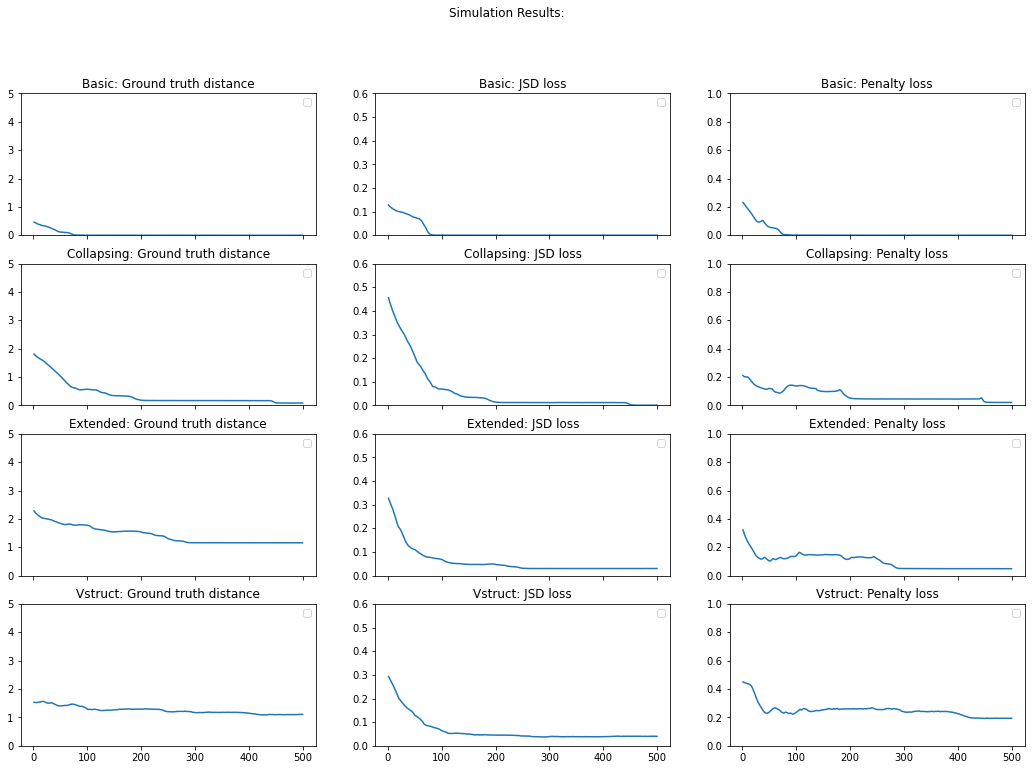

In [30]:

fig, ((ax0, ax1, ax2), (ax3, ax4, ax5), (ax6, ax7, ax8), (ax9, ax10, ax11)) = plt.subplots(nrows=4, ncols=3, sharex=True,
                                    figsize=(18, 12))
time_epoch = np.array([i+1 for i in range(num_epochs)])
ax0.set_title('Basic: Ground truth distance')
ax0.plot(time_epoch, avg_dis1)
ax0.set_ylim([0,5])
ax0.legend()

ax1.set_title('Basic: JSD loss')
ax1.plot(time_epoch, avg_jsd1)
ax1.set_ylim([0,0.6])
ax1.legend()

ax2.set_title('Basic: Penalty loss')
ax2.plot(time_epoch, avg_pen1)
ax2.set_ylim([0,1])
ax2.legend()

ax3.set_title('Collapsing: Ground truth distance')
ax3.plot(time_epoch, avg_dis2)
ax3.set_ylim([0,5])
ax3.legend()

ax4.set_title('Collapsing: JSD loss')
ax4.plot(time_epoch, avg_jsd2)
ax4.set_ylim([0,0.6])
ax4.legend()

ax5.set_title('Collapsing: Penalty loss')
ax5.plot(time_epoch, avg_pen2)
ax5.set_ylim([0,1])
ax5.legend()

ax6.set_title('Extended: Ground truth distance')
ax6.plot(time_epoch, avg_dis3)
ax6.set_ylim([0,5])
ax6.legend()

ax7.set_title('Extended: JSD loss')
ax7.plot(time_epoch, avg_jsd3)
ax7.set_ylim([0,0.6])
ax7.legend()

ax8.set_title('Extended: Penalty loss')
ax8.plot(time_epoch, avg_pen3)
ax8.set_ylim([0,1])
ax8.legend()

ax9.set_title('Vstruct: Ground truth distance')
ax9.plot(time_epoch, avg_dis4)
ax9.set_ylim([0,5])
ax9.legend()

ax10.set_title('Vstruct: JSD loss')
ax10.plot(time_epoch, avg_jsd4)
ax10.set_ylim([0,0.6])
ax10.legend()

ax11.set_title('Vstruct: Penalty loss')
ax11.plot(time_epoch, avg_pen4)
ax11.set_ylim([0,1])
ax11.legend()

fig.suptitle('Simulation Results:')
plt.show()

In [31]:
# Save results
np.save('./results/synthetic/a/avg-best-distance-app2-basic', n_best_distance1)
np.save('./results/synthetic/a/avg-best-JSD-app2-basic', n_best_jsd1)
np.save('./results/synthetic/a/avg-best-penalty-app2-basic', n_best_pen1)
np.save('./results/synthetic/a/avg-best-time-app2-basic', n_time1)
np.save('./results/synthetic/a/avg-best-endresults-app2-basic', n_best_end_results1)

np.save('./results/synthetic/a/avg-best-distance-app2-collapsing', n_best_distance2)
np.save('./results/synthetic/a/avg-best-JSD-app2-collapsing', n_best_jsd2)
np.save('./results/synthetic/a/avg-best-penalty-app2-collapsing', n_best_pen2)
np.save('./results/synthetic/a/avg-best-time-app2-collapsing', n_time2)
np.save('./results/synthetic/a/avg-best-endresults-app2-collapsing', n_best_end_results2)

np.save('./results/synthetic/a/avg-best-distance-app2-extended', n_best_distance3)
np.save('./results/synthetic/a/avg-best-JSD-app2-extended', n_best_jsd3)
np.save('./results/synthetic/a/avg-best-penalty-app2-extended', n_best_pen3)
np.save('./results/synthetic/a/avg-best-time-app2-extended', n_time3)
np.save('./results/synthetic/a/avg-best-endresults-app2-extended', n_best_end_results3)

np.save('./results/synthetic/a/avg-best-distance-app2-vstruct', n_best_distance4)
np.save('./results/synthetic/a/avg-best-JSD-app2-vstruct', n_best_jsd4)
np.save('./results/synthetic/a/avg-best-penalty-app2-vstruct', n_best_pen4)
np.save('./results/synthetic/a/avg-best-time-app2-vstruct', n_time4)
np.save('./results/synthetic/a/avg-best-endresults-app2-vstruct', n_best_end_results4)